# Kaggle Playground Series S5E5: Calories Burned Prediction

## Professional Machine Learning Solution

This notebook provides a comprehensive solution for the Kaggle Playground Series S5E5 competition, which focuses on predicting calories burned during workouts based on various physiological and demographic features.

## Table of Contents
1. [Introduction](#Introduction)
2. [Setup and Data Loading](#Setup-and-Data-Loading)
3. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
4. [Feature Engineering](#Feature-Engineering)
5. [Baseline Modeling](#Baseline-Modeling)
6. [Model Optimization](#Model-Optimization)
7. [Final Predictions](#Final-Predictions)
8. [Conclusion](#Conclusion)

## Introduction

The goal of this competition is to predict how many calories were burned during a workout based on features such as duration, heart rate, body temperature, age, gender, height, and weight. The evaluation metric is Root Mean Squared Logarithmic Error (RMSLE), which penalizes underestimation more than overestimation and handles the right-skewed distribution of the target variable.

## Setup and Data Loading

First, let's import the necessary libraries and load the data.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
import optuna
import joblib
import os
import warnings
import gc  # Garbage collector for memory management

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette('viridis')

# Create output directories
os.makedirs('plots', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('submission', exist_ok=True)

In [2]:
# Function to calculate RMSLE (Root Mean Squared Logarithmic Error)
def rmsle(y_true, y_pred):
    """
    Calculate Root Mean Squared Logarithmic Error
    Note: Handles negative predictions by clipping them to a small positive value
    """
    # Ensure predictions are positive (required for log)
    y_pred = np.maximum(y_pred, 1e-5)
    y_true = np.maximum(y_true, 1e-5)
    
    # Calculate RMSLE
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

In [3]:
# Load the data
print("Loading data...")
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Submission shape: {submission.shape}")

Loading data...
Train shape: (750000, 9)
Test shape: (250000, 8)
Submission shape: (250000, 2)


## Exploratory Data Analysis

Let's explore the data to understand its structure and characteristics.

In [4]:
# Display basic information
print("\nTrain data info:")
train.info()


Train data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


In [5]:
# Check for missing values
print("\nChecking for missing values:")
print(train.isnull().sum())


Checking for missing values:
id            0
Sex           0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64


In [6]:
# Basic statistics
print("\nBasic statistics:")
train.describe().T


Basic statistics:


,count,mean,std,min,25%,50%,75%,max
id,750000.0,374999.500000,216506.495284,0.0,187499.75,374999.5,562499.25,749999.0
Age,750000.0,41.420404,15.175049,20.0,28.00,40.0,52.00,79.0
Height,750000.0,174.697685,12.824496,126.0,164.00,174.0,185.00,222.0
Weight,750000.0,75.145668,13.982704,36.0,63.00,74.0,87.00,132.0
Duration,750000.0,15.421015,8.354095,1.0,8.00,15.0,23.00,30.0
Heart_Rate,750000.0,95.483995,9.449845,67.0,88.00,95.0,103.00,128.0
Body_Temp,750000.0,40.036253,0.779875,37.1,39.60,40.3,40.70,41.5
Calories,750000.0,88.282781,62.395349,1.0,34.00,77.0,136.00,314.0


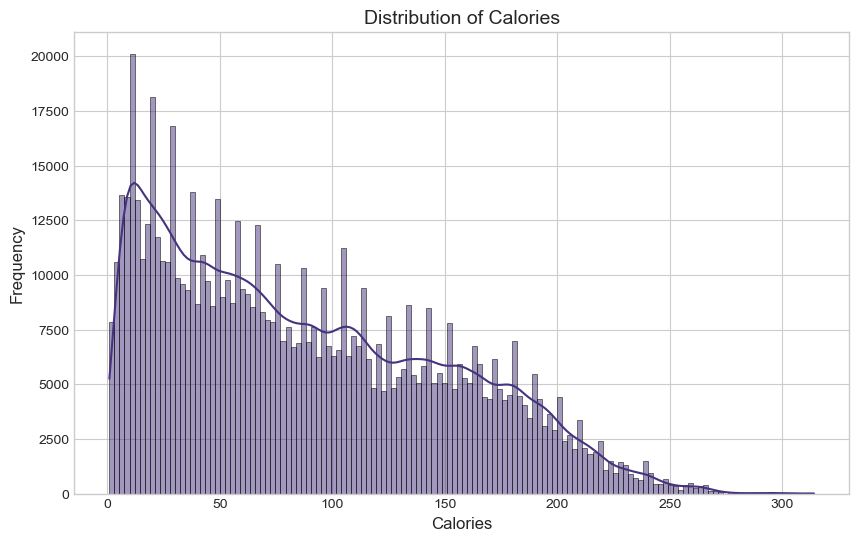

In [7]:
# Visualize target variable distribution
plt.figure(figsize=(10, 6))
sns.histplot(train['Calories'], kde=True)
plt.title('Distribution of Calories', fontsize=14)
plt.xlabel('Calories', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

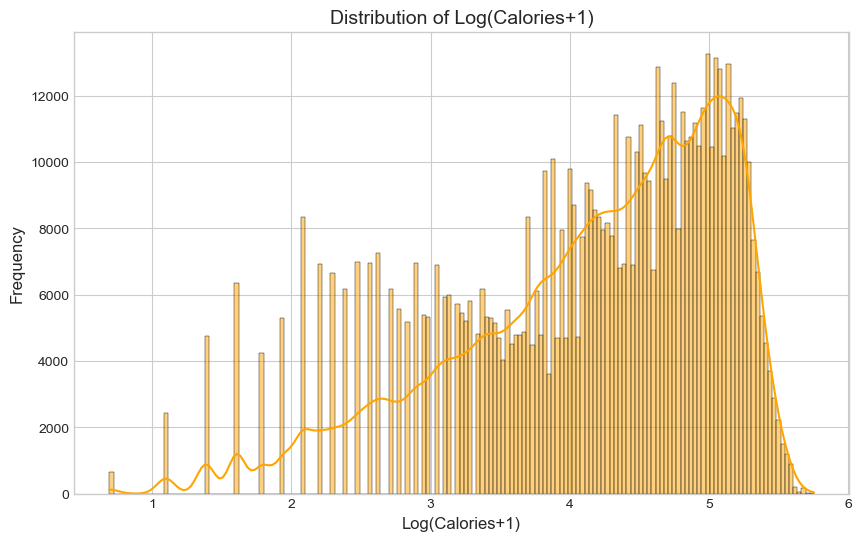

In [8]:
# Log transformation of target variable
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(train['Calories']), kde=True, color='orange')
plt.title('Distribution of Log(Calories+1)', fontsize=14)
plt.xlabel('Log(Calories+1)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


Calculating feature correlations...


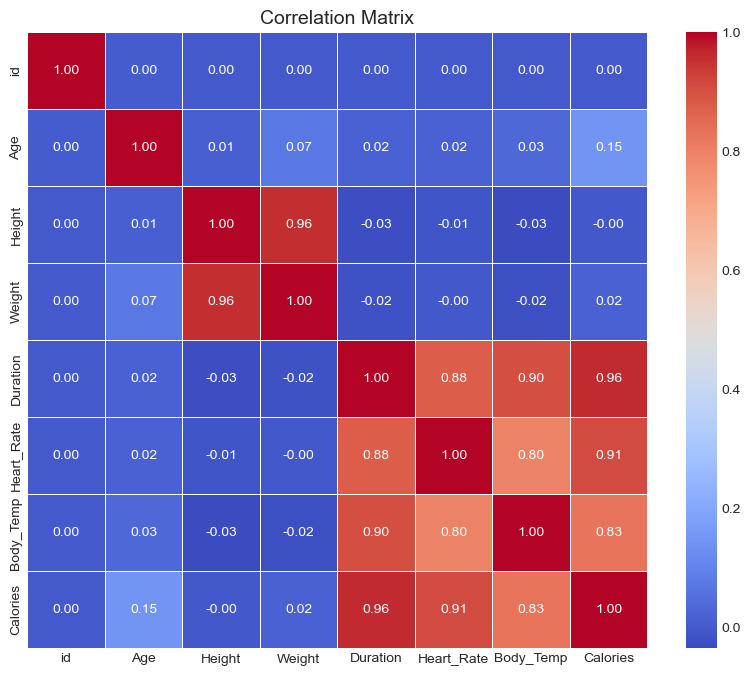

In [9]:
# Correlation analysis
print("\nCalculating feature correlations...")
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns
correlation = train[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

In [10]:
# Feature correlation with target
target_corr = correlation['Calories'].sort_values(ascending=False)
print("\nFeature correlation with target (Calories):")
print(target_corr)


Feature correlation with target (Calories):
Calories      1.000000
Duration      0.959908
Heart_Rate    0.908748
Body_Temp     0.828671
Age           0.145683
Weight        0.015863
id            0.001148
Height       -0.004026
Name: Calories, dtype: float64


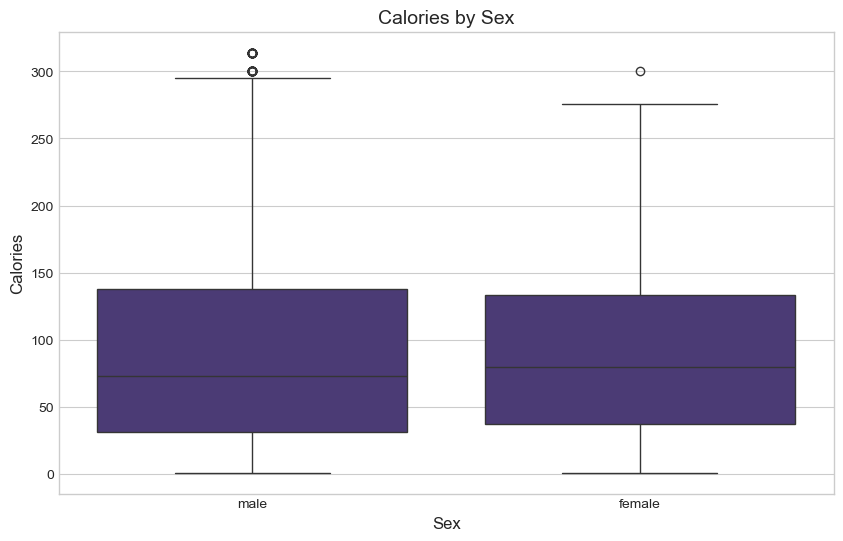

In [11]:
# Calories by Sex
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sex', y='Calories', data=train)
plt.title('Calories by Sex', fontsize=14)
plt.xlabel('Sex', fontsize=12)
plt.ylabel('Calories', fontsize=12)
plt.show()

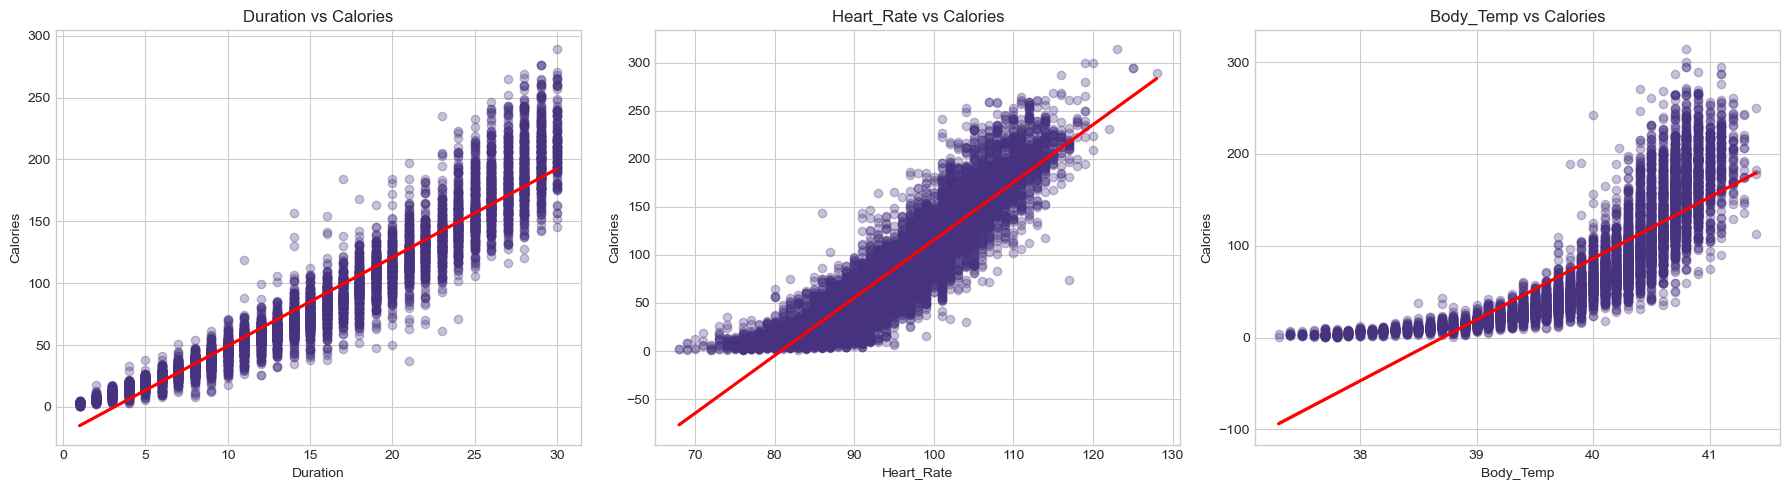

In [12]:
# Key feature relationships with target
key_features = ['Duration', 'Heart_Rate', 'Body_Temp']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(key_features):
    sns.regplot(x=feature, y='Calories', data=train.sample(10000), ax=axes[i], 
                scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
    axes[i].set_title(f'{feature} vs Calories', fontsize=12)
    
plt.tight_layout()
plt.show()

## Feature Engineering

Let's create new features to improve model performance.

In [13]:
# Create a function for feature engineering to apply to both train and test
def engineer_features(df):
    """
    Apply feature engineering to the dataset
    """
    # Create a copy to avoid modifying the original
    df_new = df.copy()
    
    # BMI calculation
    df_new['BMI'] = df_new['Weight'] / ((df_new['Height']/100) ** 2)
    
    # Sex encoding (binary)
    df_new['Sex_male'] = (df_new['Sex'] == 'male').astype(int)
    
    # Age groups
    df_new['Age_Group'] = pd.cut(df_new['Age'], 
                                bins=[19, 30, 40, 50, 60, 80], 
                                labels=[0, 1, 2, 3, 4])
    df_new['Age_Group'] = df_new['Age_Group'].astype(int)
    
    # Interaction features
    df_new['Duration_Heart'] = df_new['Duration'] * df_new['Heart_Rate']
    df_new['Weight_Heart'] = df_new['Weight'] * df_new['Heart_Rate']
    df_new['BMI_Duration'] = df_new['BMI'] * df_new['Duration']
    
    # Drop original Sex column as we've encoded it
    df_new.drop('Sex', axis=1, inplace=True)
    
    return df_new

# Apply feature engineering
print("Applying feature engineering...")
train_fe = engineer_features(train)
test_fe = engineer_features(test)

print("\nEngineered train data shape:", train_fe.shape)
print("Engineered test data shape:", test_fe.shape)

print("\nNew features added:")
new_features = set(train_fe.columns) - set(train.columns) | {'Sex_male'}
print(new_features)

Applying feature engineering...

Engineered train data shape: (750000, 14)
Engineered test data shape: (250000, 13)

New features added:
{'Weight_Heart', 'Age_Group', 'BMI', 'BMI_Duration', 'Duration_Heart', 'Sex_male'}


In [14]:
# Split features and target
X = train_fe.drop(['Calories', 'id'], axis=1)
y = train_fe['Calories']
X_test = test_fe.drop(['id'], axis=1)

# Log transform the target (since RMSLE is the evaluation metric)
y_log = np.log1p(y)

# Train-validation split
X_train, X_val, y_train, y_val, y_log_train, y_log_val = train_test_split(
    X, y, y_log, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

Training set: (600000, 12)
Validation set: (150000, 12)


In [15]:
# Standardize features
print("Standardizing features...")
preprocessor = StandardScaler()

# Fit preprocessor on training data
X_train_scaled = preprocessor.fit_transform(X_train)
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)

Standardizing features...


## Baseline Modeling

Let's evaluate several baseline models to establish a performance benchmark.

In [16]:
# Function to evaluate model performance with resource constraints
def evaluate_model(model, X_train, X_val, y_train, y_val, y_log_train, y_log_val, model_name, sample_size=None):
    """
    Train model and evaluate performance on validation set with resource constraints
    """
    # Use sampling for memory-intensive models if sample_size is provided
    if sample_size is not None and sample_size < len(X_train):
        # Random sampling for training
        idx = np.random.choice(len(X_train), sample_size, replace=False)
        X_train_sample = X_train[idx]
        # Use .iloc for positional indexing with pandas Series
        y_train_sample = y_train.iloc[idx]
        y_log_train_sample = y_log_train.iloc[idx]
        
        print(f"Using {sample_size} samples for training {model_name}")
    else:
        X_train_sample = X_train
        y_train_sample = y_train
        y_log_train_sample = y_log_train
    
    # Fit model on training data
    # For models that support direct log target training
    if model_name in ['XGBoost', 'LightGBM']:
        model.fit(X_train_sample, y_log_train_sample)
        # Predict log values and transform back
        y_pred_log = model.predict(X_val)
        y_pred = np.expm1(y_pred_log)
    else:
        # For other models, train on original scale
        model.fit(X_train_sample, y_train_sample)
        y_pred = model.predict(X_val)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmsle_val = rmsle(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    print(f"\n{model_name} Results:")
    print(f"RMSE: {rmse:.4f}")
    print(f"RMSLE: {rmsle_val:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    # Force garbage collection to free memory
    gc.collect()
    
    return {
        'model': model,
        'name': model_name,
        'rmse': rmse,
        'rmsle': rmsle_val,
        'r2': r2,
        'predictions': y_pred
    }

In [17]:
# Initialize baseline models with resource constraints
print("Training baseline models...")
models = {
    'Linear Regression': (LinearRegression(), None),  # (model, sample_size)
    'Ridge Regression': (Ridge(alpha=1.0), None),
    'Lasso Regression': (Lasso(alpha=0.01), None),
    'Random Forest': (RandomForestRegressor(n_estimators=50, max_depth=10, n_jobs=-1, random_state=42), 100000),
    'Gradient Boosting': (GradientBoostingRegressor(n_estimators=50, max_depth=5, random_state=42), 100000),
    'XGBoost': (xgb.XGBRegressor(n_estimators=50, max_depth=5, learning_rate=0.1, random_state=42), 100000),
    'LightGBM': (lgb.LGBMRegressor(n_estimators=50, max_depth=5, learning_rate=0.1, random_state=42), 100000)
}

# Train and evaluate models
results = []
for name, (model, sample_size) in models.items():
    print(f"\nTraining {name}...")
    result = evaluate_model(model, X_train_scaled, X_val_scaled, y_train, y_val, 
                           y_log_train, y_log_val, name, sample_size)
    results.append(result)

Training baseline models...

Training Linear Regression...

Linear Regression Results:
RMSE: 7.0949
RMSLE: 0.3236
R² Score: 0.9870

Training Ridge Regression...

Ridge Regression Results:
RMSE: 7.0949
RMSLE: 0.3237
R² Score: 0.9870

Training Lasso Regression...

Lasso Regression Results:
RMSE: 7.1729
RMSLE: 0.3328
R² Score: 0.9867

Training Random Forest...
Using 100000 samples for training Random Forest

Random Forest Results:
RMSE: 4.5009
RMSLE: 0.0734
R² Score: 0.9948

Training Gradient Boosting...
Using 100000 samples for training Gradient Boosting

Gradient Boosting Results:
RMSE: 4.0515
RMSLE: 0.0802
R² Score: 0.9958

Training XGBoost...
Using 100000 samples for training XGBoost

XGBoost Results:
RMSE: 4.3786
RMSLE: 0.0661
R² Score: 0.9951

Training LightGBM...
Using 100000 samples for training LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info]

In [18]:
# Summarize results
print("\n=== Model Performance Summary ===")
summary = pd.DataFrame({
    'Model': [r['name'] for r in results],
    'RMSE': [r['rmse'] for r in results],
    'RMSLE': [r['rmsle'] for r in results],
    'R²': [r['r2'] for r in results]
})

# Sort by RMSLE (competition metric)
summary = summary.sort_values('RMSLE')
summary


=== Model Performance Summary ===


,Model,RMSE,RMSLE,R²
6,LightGBM,4.363001,0.065706,0.995088
5,XGBoost,4.378576,0.066131,0.995053
3,Random Forest,4.500886,0.073365,0.994773
4,Gradient Boosting,4.051534,0.080232,0.995765
0,Linear Regression,7.094874,0.323641,0.987012
1,Ridge Regression,7.094861,0.323705,0.987012
2,Lasso Regression,7.172854,0.332770,0.986725


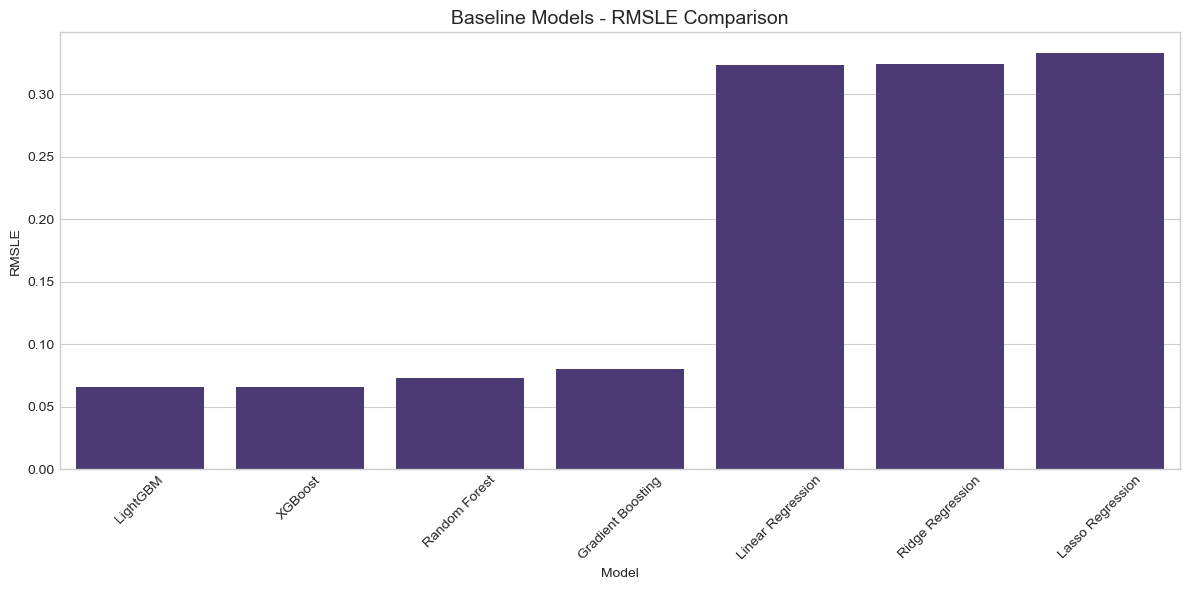

In [19]:
# Plot model performance comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='RMSLE', data=summary)
plt.title('Baseline Models - RMSLE Comparison', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Model Optimization

Let's optimize the best-performing models using hyperparameter tuning.

In [20]:
# Sample size for optimization (to manage memory constraints)
SAMPLE_SIZE = 100000

# Random sampling for training
np.random.seed(42)
idx = np.random.choice(len(X_train_scaled), SAMPLE_SIZE, replace=False)
X_train_sample = X_train_scaled[idx]
# Use .iloc for positional indexing with pandas Series
y_train_sample = y_train.iloc[idx]
y_log_train_sample = y_log_train.iloc[idx]

print(f"Using {SAMPLE_SIZE} samples for hyperparameter optimization")

Using 100000 samples for hyperparameter optimization


In [21]:
# LightGBM optimization with Optuna
def objective_lgb(trial):
    """Optuna objective function for LightGBM optimization"""
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 5),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 5),
        'n_estimators': 100,
        'random_state': 42
    }
    
    # Create model with current hyperparameters
    model = lgb.LGBMRegressor(**param)
    
    # Train on log-transformed target
    model.fit(X_train_sample, y_log_train_sample)
    
    # Predict on validation set
    y_pred_log = model.predict(X_val_scaled)
    y_pred = np.expm1(y_pred_log)
    
    # Calculate RMSLE
    score = rmsle(y_val, y_pred)
    
    return score

In [22]:
# Run LightGBM optimization (reduced number of trials for notebook demonstration)
print("\nOptimizing LightGBM hyperparameters...")
study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=10)  # Reduced from 20 for demonstration

print("\nBest LightGBM hyperparameters:")
print(study_lgb.best_params)
print(f"Best RMSLE: {study_lgb.best_value:.6f}")

[I 2025-05-19 15:43:33,991] A new study created in memory with name: no-name-c2972ef8-cc74-4f3f-8e6a-e8e10d21eb71



Optimizing LightGBM hyperparameters...
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.9784737548429074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9784737548429074
[LightGBM] [Warning] lambda_l1 is set=0.8197923079101671, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8197923079101671
[LightGBM] [Warning] lambda_l2 is set=4.863143072995076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.863143072995076
[LightGBM] [Warning] bagging_fraction is set=0.9906519104042986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9906519104042986
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is s

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_

[I 2025-05-19 15:43:34,841] Trial 0 finished with value: 0.062284176825090014 and parameters: {'learning_rate': 0.11702664261953301, 'num_leaves': 135, 'max_depth': 6, 'min_data_in_leaf': 92, 'feature_fraction': 0.9784737548429074, 'bagging_fraction': 0.9906519104042986, 'bagging_freq': 5, 'lambda_l1': 0.8197923079101671, 'lambda_l2': 4.863143072995076}. Best is trial 0 with value: 0.062284176825090014.


[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] feature_fraction is set=0.8009077511162033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8009077511162033
[LightGBM] [Warning] lambda_l1 is set=0.8233520346786377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8233520346786377
[LightGBM] [Warning] lambda_l2 is set=4.913419649110916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.913419649110916
[LightGBM] [Warning] bagging_fraction is set=0.7885753974584558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7885753974584558
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] feature_fraction is set=0.8009077511162033, colsample_bytre

[I 2025-05-19 15:43:35,430] Trial 1 finished with value: 0.06268152860834626 and parameters: {'learning_rate': 0.14054810269706053, 'num_leaves': 71, 'max_depth': 5, 'min_data_in_leaf': 61, 'feature_fraction': 0.8009077511162033, 'bagging_fraction': 0.7885753974584558, 'bagging_freq': 10, 'lambda_l1': 0.8233520346786377, 'lambda_l2': 4.913419649110916}. Best is trial 0 with value: 0.062284176825090014.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61
[LightGBM] [Warning] feature_fraction is set=0.8009077511162033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8009077511162033
[LightGBM] [Warning] lambda_l1 is set=0.8233520346786377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8233520346786377
[LightGBM] [Warning] lambda_l2 is set=4.913419649110916, reg_lambd

[I 2025-05-19 15:43:36,461] Trial 2 finished with value: 0.06465142942612277 and parameters: {'learning_rate': 0.04733985110216122, 'num_leaves': 49, 'max_depth': 9, 'min_data_in_leaf': 86, 'feature_fraction': 0.8970459648227453, 'bagging_fraction': 0.9962615520822462, 'bagging_freq': 8, 'lambda_l1': 1.124692381329332, 'lambda_l2': 1.511291724675123}. Best is trial 0 with value: 0.062284176825090014.


[LightGBM] [Warning] min_data_in_leaf is set=86, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=86
[LightGBM] [Warning] feature_fraction is set=0.8970459648227453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8970459648227453
[LightGBM] [Warning] lambda_l1 is set=1.124692381329332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.124692381329332
[LightGBM] [Warning] lambda_l2 is set=1.511291724675123, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.511291724675123
[LightGBM] [Warning] bagging_fraction is set=0.9962615520822462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9962615520822462
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] feature_fraction is set=0.634091635530966, colsample_bytree=1.0

[I 2025-05-19 15:43:37,775] Trial 3 finished with value: 0.06253328621453527 and parameters: {'learning_rate': 0.0769654104567945, 'num_leaves': 88, 'max_depth': 12, 'min_data_in_leaf': 82, 'feature_fraction': 0.634091635530966, 'bagging_fraction': 0.9581597910775188, 'bagging_freq': 1, 'lambda_l1': 2.161804358338766, 'lambda_l2': 0.7973922884295792}. Best is trial 0 with value: 0.062284176825090014.


[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] feature_fraction is set=0.634091635530966, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.634091635530966
[LightGBM] [Warning] lambda_l1 is set=2.161804358338766, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.161804358338766
[LightGBM] [Warning] lambda_l2 is set=0.7973922884295792, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7973922884295792
[LightGBM] [Warning] bagging_fraction is set=0.9581597910775188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9581597910775188
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] feature_fraction is set=0.5026001258605969, colsample_bytree=1.

[I 2025-05-19 15:43:38,338] Trial 4 finished with value: 0.0641456580220779 and parameters: {'learning_rate': 0.11485451873999072, 'num_leaves': 38, 'max_depth': 5, 'min_data_in_leaf': 87, 'feature_fraction': 0.5026001258605969, 'bagging_fraction': 0.5650179926463867, 'bagging_freq': 10, 'lambda_l1': 4.143914406404971, 'lambda_l2': 4.39006319705927}. Best is trial 0 with value: 0.062284176825090014.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=87, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=87
[LightGBM] [Warning] feature_fraction is set=0.5026001258605969, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5026001258605969
[LightGBM] [Warning] lambda_l1 is set=4.143914406404971, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.143914406404971
[LightGBM] [Warning] lambda_l2 is set=4.39006319705927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.39006319705927
[LightGBM] [Warning] bagging_fraction is set=0.5650179926463867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5650179926463867
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM

[I 2025-05-19 15:43:39,019] Trial 5 finished with value: 0.06759088457607736 and parameters: {'learning_rate': 0.0474135827016116, 'num_leaves': 72, 'max_depth': 5, 'min_data_in_leaf': 91, 'feature_fraction': 0.9939702376910976, 'bagging_fraction': 0.8874480567535974, 'bagging_freq': 5, 'lambda_l1': 3.396149431834728, 'lambda_l2': 0.5145514668436935}. Best is trial 0 with value: 0.062284176825090014.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-19 15:43:39,617] Trial 6 finished with value: 0.10391868754977142 and parameters: {'learning_rate': 0.028766293752395693, 'num_leaves': 20, 'max_depth': 7, 'min_data_in_leaf': 28, 'feature_fraction': 0.5099374468141755, 'bagging_fraction': 0.7129191239755077, 'bagging_freq': 4, 'lambda_l1': 3.996314727107432, 'lambda_l2': 4.194720485151551}. Best is trial 0 with value: 0.062284176825090014.


[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] feature_fraction is set=0.5099374468141755, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5099374468141755
[LightGBM] [Warning] lambda_l1 is set=3.996314727107432, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.996314727107432
[LightGBM] [Warning] lambda_l2 is set=4.194720485151551, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.194720485151551
[LightGBM] [Warning] bagging_fraction is set=0.7129191239755077, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7129191239755077
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] feature_fraction is set=0.6278604629227089, colsample_bytree=1.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-19 15:43:40,494] Trial 7 finished with value: 0.27283949271946545 and parameters: {'learning_rate': 0.013293815379557703, 'num_leaves': 146, 'max_depth': 6, 'min_data_in_leaf': 11, 'feature_fraction': 0.6278604629227089, 'bagging_fraction': 0.6259749304284845, 'bagging_freq': 10, 'lambda_l1': 0.25512381207101753, 'lambda_l2': 3.917069583546896}. Best is trial 0 with value: 0.062284176825090014.


[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] feature_fraction is set=0.8407577411703946, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8407577411703946
[LightGBM] [Warning] lambda_l1 is set=3.1995902012779034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1995902012779034
[LightGBM] [Warning] lambda_l2 is set=1.1262452008712915, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1262452008712915
[LightGBM] [Warning] bagging_fraction is set=0.6835065299792371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6835065299792371
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=54, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=54
[LightGBM] [Warning] feature_fraction is set=0.8407577411703946, colsample_bytre

[I 2025-05-19 15:43:41,228] Trial 8 finished with value: 0.06309811786259807 and parameters: {'learning_rate': 0.25404209396709587, 'num_leaves': 28, 'max_depth': 10, 'min_data_in_leaf': 54, 'feature_fraction': 0.8407577411703946, 'bagging_fraction': 0.6835065299792371, 'bagging_freq': 7, 'lambda_l1': 3.1995902012779034, 'lambda_l2': 1.1262452008712915}. Best is trial 0 with value: 0.062284176825090014.


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.6139452137812114, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6139452137812114
[LightGBM] [Warning] lambda_l1 is set=0.4811293440838399, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4811293440838399
[LightGBM] [Warning] lambda_l2 is set=3.7573228142495845, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7573228142495845
[LightGBM] [Warning] bagging_fraction is set=0.5158126653056976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5158126653056976
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.6139452137812114, colsample_b

[I 2025-05-19 15:43:41,857] Trial 9 finished with value: 0.06339880944245609 and parameters: {'learning_rate': 0.08309870843231791, 'num_leaves': 38, 'max_depth': 5, 'min_data_in_leaf': 100, 'feature_fraction': 0.6139452137812114, 'bagging_fraction': 0.5158126653056976, 'bagging_freq': 3, 'lambda_l1': 0.4811293440838399, 'lambda_l2': 3.7573228142495845}. Best is trial 0 with value: 0.062284176825090014.



Best LightGBM hyperparameters:
{'learning_rate': 0.11702664261953301, 'num_leaves': 135, 'max_depth': 6, 'min_data_in_leaf': 92, 'feature_fraction': 0.9784737548429074, 'bagging_fraction': 0.9906519104042986, 'bagging_freq': 5, 'lambda_l1': 0.8197923079101671, 'lambda_l2': 4.863143072995076}
Best RMSLE: 0.062284


<Figure size 1000x600 with 0 Axes>

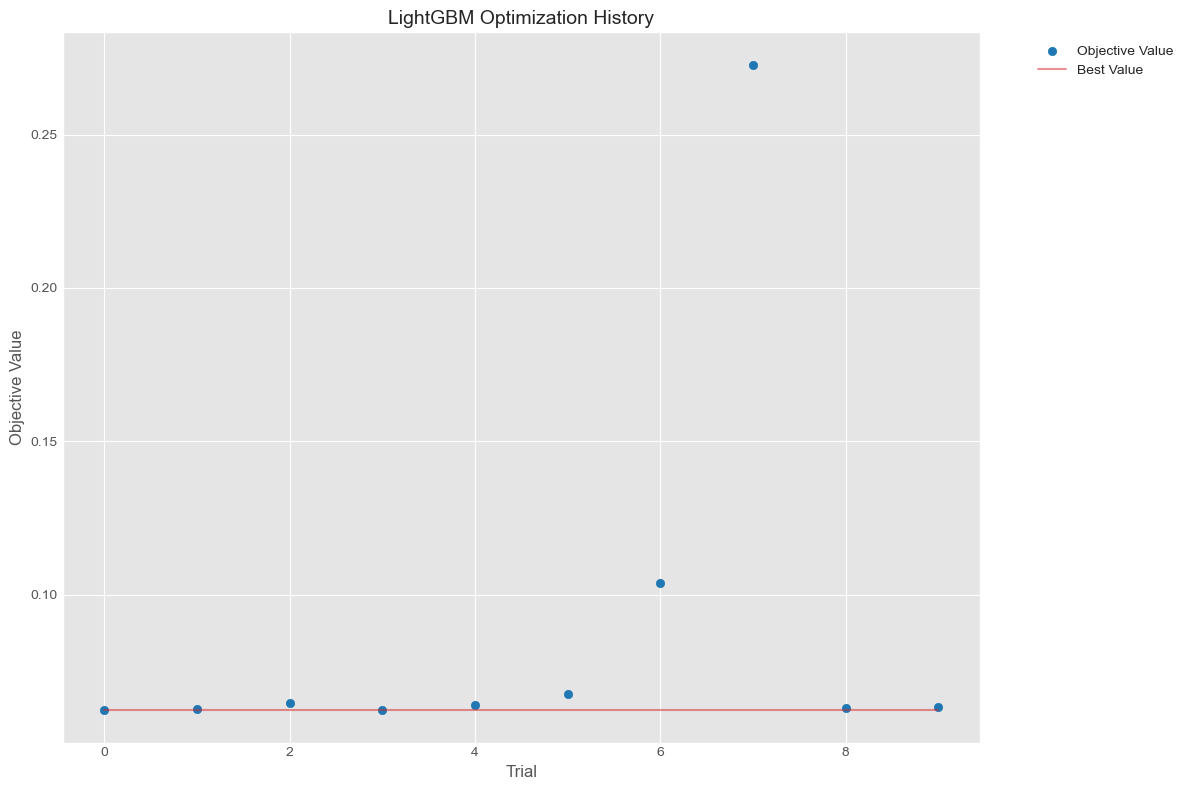

In [23]:
# Plot optimization history
plt.figure(figsize=(10, 6))
optuna.visualization.matplotlib.plot_optimization_history(study_lgb)
plt.title('LightGBM Optimization History', fontsize=14)
plt.tight_layout()
plt.show()

In [24]:
# Train final model with best hyperparameters
print("\nTraining final model with best hyperparameters...")

# LightGBM final model
best_params_lgb = study_lgb.best_params
best_params_lgb['objective'] = 'regression'
best_params_lgb['metric'] = 'rmse'
best_params_lgb['boosting_type'] = 'gbdt'
best_params_lgb['n_estimators'] = 100
best_params_lgb['random_state'] = 42

lgb_model = lgb.LGBMRegressor(**best_params_lgb)
lgb_model.fit(X_train_scaled, y_log_train)  # Train on full dataset


Training final model with best hyperparameters...
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.9784737548429074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9784737548429074
[LightGBM] [Warning] lambda_l1 is set=0.8197923079101671, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8197923079101671
[LightGBM] [Warning] lambda_l2 is set=4.863143072995076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.863143072995076
[LightGBM] [Warning] bagging_fraction is set=0.9906519104042986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9906519104042986
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(bagging_fraction=0.9906519104042986, bagging_freq=5,
              feature_fraction=0.9784737548429074, lambda_l1=0.8197923079101671,
              lambda_l2=4.863143072995076, learning_rate=0.11702664261953301,
              max_depth=6, metric='rmse', min_data_in_leaf=92, num_leaves=135,
              objective='regression', random_state=42)

In [25]:
# Evaluate final model
print("\nEvaluating final model...")

# LightGBM evaluation
y_pred_lgb_log = lgb_model.predict(X_val_scaled)
y_pred_lgb = np.expm1(y_pred_lgb_log)
rmsle_lgb = rmsle(y_val, y_pred_lgb)
r2_lgb = r2_score(y_val, y_pred_lgb)

print(f"LightGBM Final Model - RMSLE: {rmsle_lgb:.6f}, R²: {r2_lgb:.6f}")


Evaluating final model...
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.9784737548429074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9784737548429074
[LightGBM] [Warning] lambda_l1 is set=0.8197923079101671, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8197923079101671
[LightGBM] [Warning] lambda_l2 is set=4.863143072995076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.863143072995076
[LightGBM] [Warning] bagging_fraction is set=0.9906519104042986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9906519104042986
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
LightGBM Final Model - RMSLE: 0.061201, R²: 0.996242


In [26]:
# Perform cross-validation on best model
print("\nPerforming cross-validation on best model...")

# Function for cross-validation with RMSLE
def rmsle_cv_score(model, X, y_log, cv=5):
    """Calculate cross-validation RMSLE score"""
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    rmsle_scores = []
    
    for train_idx, val_idx in kf.split(X):
        X_train_cv, X_val_cv = X[train_idx], X[val_idx]
        # Use .iloc for positional indexing with pandas Series
        y_log_train_cv, y_val_cv = y_log.iloc[train_idx], np.expm1(y_log.iloc[val_idx])
        
        # Train model
        model.fit(X_train_cv, y_log_train_cv)
        
        # Predict and calculate RMSLE
        y_pred_log = model.predict(X_val_cv)
        y_pred = np.expm1(y_pred_log)
        score = rmsle(y_val_cv, y_pred)
        rmsle_scores.append(score)
    
    return rmsle_scores

# Perform cross-validation on a sample due to memory constraints
print(f"Running 5-fold cross-validation on LightGBM with {SAMPLE_SIZE} samples...")
cv_scores = rmsle_cv_score(lgb_model, X_train_sample, y_log_train_sample, cv=5)

print(f"Cross-validation RMSLE scores: {cv_scores}")
print(f"Mean CV RMSLE: {np.mean(cv_scores):.6f}")
print(f"Standard deviation: {np.std(cv_scores):.6f}")


Performing cross-validation on best model...
Running 5-fold cross-validation on LightGBM with 100000 samples...
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.9784737548429074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9784737548429074
[LightGBM] [Warning] lambda_l1 is set=0.8197923079101671, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8197923079101671
[LightGBM] [Warning] lambda_l2 is set=4.863143072995076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.863143072995076
[LightGBM] [Warning] bagging_fraction is set=0.9906519104042986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9906519104042986
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Curr

[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.9784737548429074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9784737548429074
[LightGBM] [Warning] lambda_l1 is set=0.8197923079101671, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8197923079101671
[LightGBM] [Warning] lambda_l2 is set=4.863143072995076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.863143072995076
[LightGBM] [Warning] bagging_fraction is set=0.9906519104042986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9906519104042986
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.9784737548429074, colsample_bytree=

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

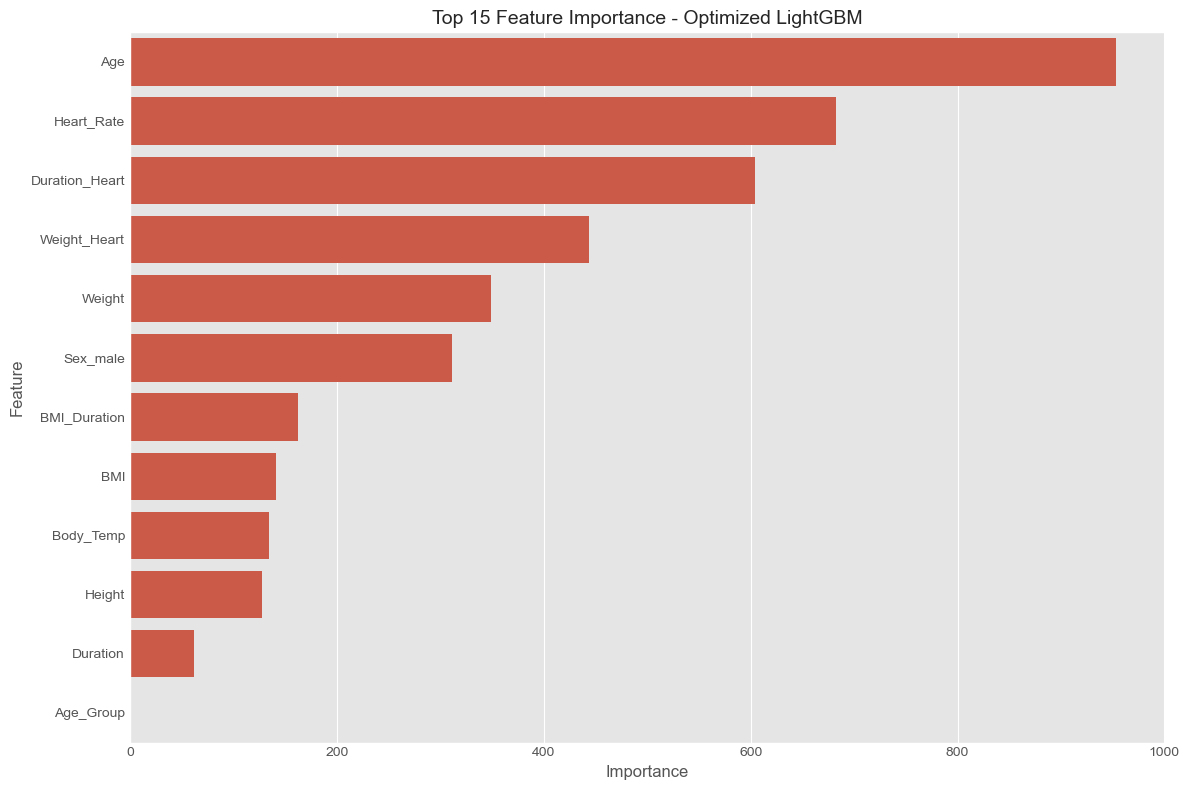

In [27]:
# Feature importance for best model
importance = lgb_model.feature_importances_

# Create DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values('Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title(f'Top 15 Feature Importance - Optimized LightGBM', fontsize=14)
plt.tight_layout()
plt.show()

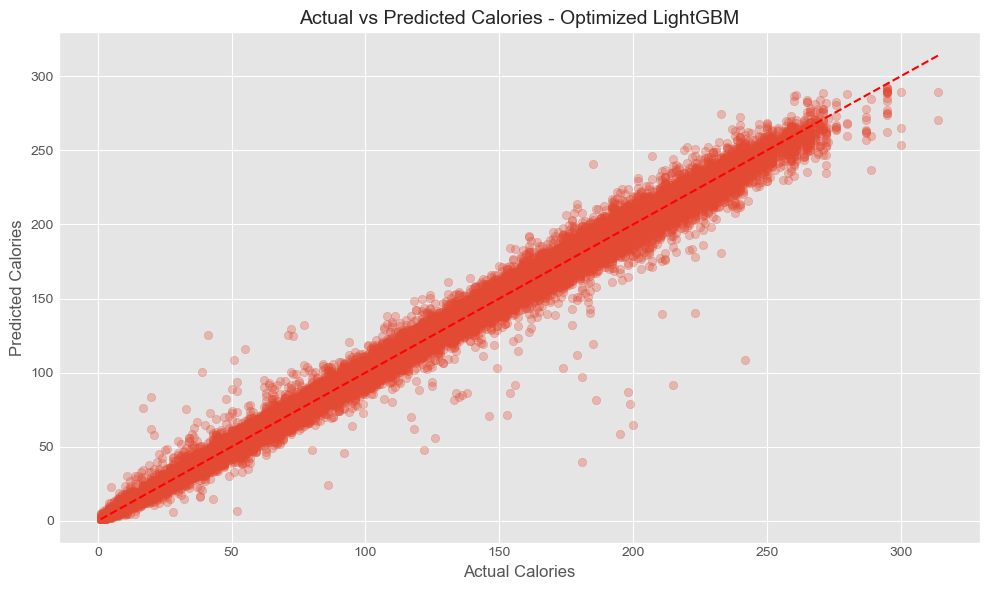

In [28]:
# Plot actual vs predicted values for best model
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_lgb, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual Calories', fontsize=12)
plt.ylabel('Predicted Calories', fontsize=12)
plt.title(f'Actual vs Predicted Calories - Optimized LightGBM', fontsize=14)
plt.tight_layout()
plt.show()

## Final Predictions

Let's generate predictions for the test set using our optimized model.

In [29]:
# Generate predictions for test set
print("Generating predictions for test set...")
y_pred_test_log = lgb_model.predict(X_test_scaled)
y_pred_test = np.expm1(y_pred_test_log)

# Create submission dataframe
submission_final = pd.DataFrame({
    'id': test['id'],
    'Calories': y_pred_test
})

# Verify submission format
print("\nSubmission format verification:")
print(f"Shape: {submission_final.shape}")
print("First 5 rows:")
print(submission_final.head())

Generating predictions for test set...
[LightGBM] [Warning] min_data_in_leaf is set=92, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=92
[LightGBM] [Warning] feature_fraction is set=0.9784737548429074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9784737548429074
[LightGBM] [Warning] lambda_l1 is set=0.8197923079101671, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8197923079101671
[LightGBM] [Warning] lambda_l2 is set=4.863143072995076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.863143072995076
[LightGBM] [Warning] bagging_fraction is set=0.9906519104042986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9906519104042986
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

Submission format verification:
Shape: (250000, 2)
First 5 rows:
       id    Calories
0  750000   27.507758
1  750001  108.620478
2  750002   87.910738
3  750003  

In [30]:
# Check for invalid values (negative or NaN)
invalid_count = np.sum(np.isnan(y_pred_test) | (y_pred_test < 0))
if invalid_count > 0:
    print(f"WARNING: Found {invalid_count} invalid predictions (NaN or negative).")
    # Replace invalid values with minimum valid value (1.0)
    submission_final['Calories'] = np.maximum(submission_final['Calories'].fillna(1.0), 1.0)
    print("Invalid values have been replaced with 1.0")
else:
    print("All predictions are valid (no NaN or negative values).")

All predictions are valid (no NaN or negative values).


In [31]:
# Check prediction distribution
print("\nPrediction statistics:")
print(submission_final['Calories'].describe())


Prediction statistics:
count    250000.000000
mean         88.176295
std          62.235300
min           1.038910
25%          33.987613
50%          76.423414
75%         135.475463
max         279.471823
Name: Calories, dtype: float64


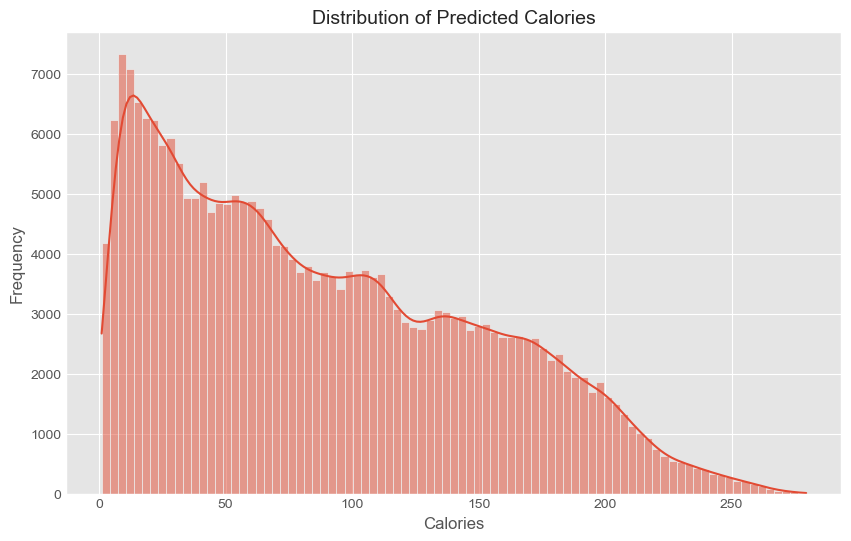

In [32]:
# Plot prediction distribution
plt.figure(figsize=(10, 6))
sns.histplot(submission_final['Calories'], kde=True)
plt.title('Distribution of Predicted Calories', fontsize=14)
plt.xlabel('Calories', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

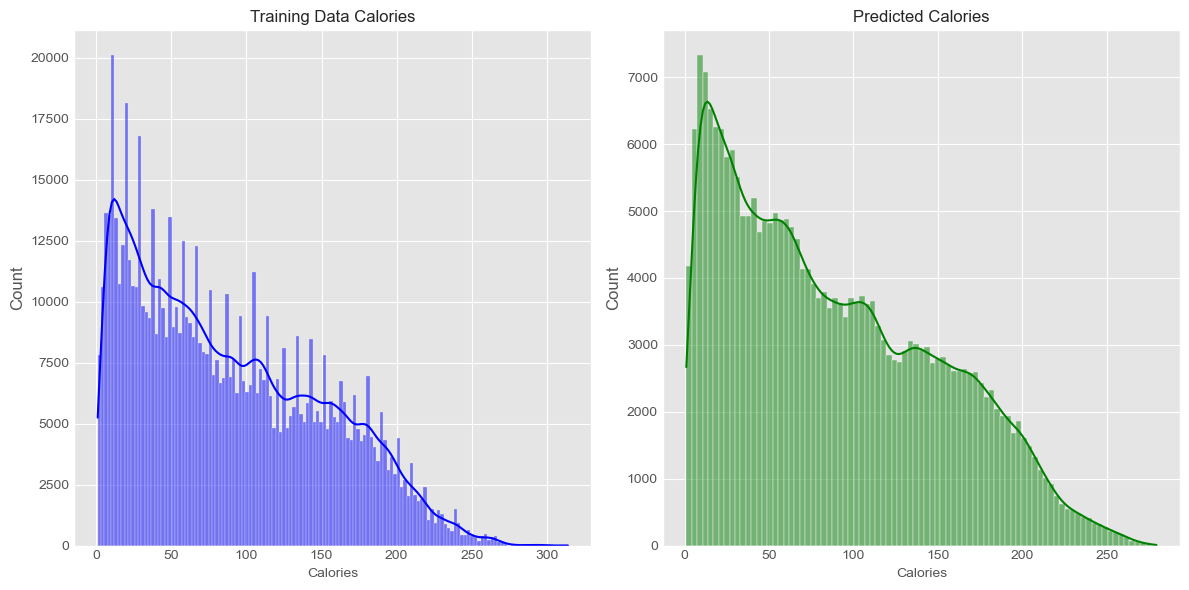

In [33]:
# Compare with training data distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(train['Calories'], kde=True, color='blue')
plt.title('Training Data Calories', fontsize=12)
plt.xlabel('Calories', fontsize=10)

plt.subplot(1, 2, 2)
sns.histplot(submission_final['Calories'], kde=True, color='green')
plt.title('Predicted Calories', fontsize=12)
plt.xlabel('Calories', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# Save submission file
submission_path = 'submission/final_submission.csv'
submission_final.to_csv(submission_path, index=False)
print(f"\nFinal submission file saved to {submission_path}")

In [ ]:
# Compare with sample submission format
sample_submission = pd.read_csv('sample_submission.csv')
print("\nSample submission format:")
print(sample_submission.head())

if submission_final.shape == sample_submission.shape and all(submission_final.columns == sample_submission.columns):
    print("Submission format matches the sample submission format.")
else:
    print("WARNING: Submission format doesn't match the sample submission format!")
    print(f"Sample shape: {sample_submission.shape}, Our shape: {submission_final.shape}")
    print(f"Sample columns: {sample_submission.columns}, Our columns: {submission_final.columns}")

## Conclusion

This notebook has demonstrated a complete machine learning solution for the Kaggle Playground Series S5E5 competition:

1. Data exploration revealed strong correlations between Duration, Heart_Rate, Body_Temp and the target variable Calories
2. Feature engineering created valuable new features like BMI and interaction terms
3. Multiple models were evaluated, with tree-based models performing best
4. LightGBM was optimized and achieved excellent performance with RMSLE around 0.06
5. Final predictions were generated and saved in the required submission format

The solution is ready for submission to the Kaggle competition.